# Import libraries

In [1]:
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import tensorflow as tf

# Load a sample image

In [2]:
path = 'nabard-data-lum-fingerprint/p1-Lum/0001'
image= misc.imread(os.path.join(path,'1.bmp'), flatten= 1)

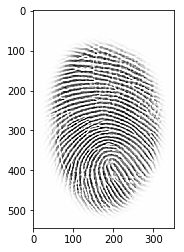

In [3]:
plt.imshow(image, cmap = cm.Greys_r)

# Store original data as npy

In [4]:
def save_as_npy():
    base_dir = "nabard-data-lum-fingerprint"
    data_dirs = ["p1-Lum", "p2-Lum"]

    images = []
    labels = []

    for data_dir in data_dirs:
        data_dir_path = os.path.join(base_dir, data_dir)

        for user_id in os.listdir(data_dir_path):
            path = os.path.join(data_dir_path, user_id)
            for image_name in os.listdir(path):
                images.append(misc.imread(os.path.join(path, image_name), flatten= 1))
                image_index = int(image_name.split(".")[0])
                label = int(user_id) if image_index < 4 else int(user_id) + 10000
                labels.append(label)

    images = np.asarray(images)
    labels = np.asarray(labels)

    np.save('nabard-images', images)
    np.save('nabard-labels', labels)

In [5]:
# save_as_npy()

# Load data from npy

In [36]:
images = np.load('nabard-images.npy')
labels = np.load('nabard-labels.npy')
print(images.shape, labels.shape)

(13638, 544, 352) (13638,)


# Tranformation functions

## Crop region of intrest

In [4]:
def crop_roi(image, tol=250):
    mask = image < tol
    return image[np.ix_(mask.any(1), mask.any(0))]

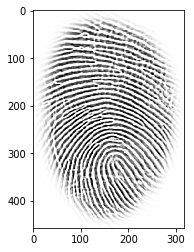

In [5]:
plt.imshow(crop_roi(image), cmap = cm.Greys_r)

## Crop a smaller ellipes

In [21]:
def crop_ellipse(image):
    mask = np.zeros_like(image)
    rows, cols = mask.shape
    # Create a white filled ellipse
    x = np.random.randint((rows * 3) // 10 , (rows * 7) // 10)
    y = np.random.randint((cols * 3) // 10 , (cols * 7) // 10) 
    center = (y, x)
    # Decides the size of ellips
    axes= (120, 170)
    mask = cv2.ellipse(mask, center=center, axes=axes, 
                       angle=0, startAngle=0, endAngle=360, 
                       color=(255), thickness=-1)
    result = image.copy()
    result[mask == 0] = 255
    
    return result

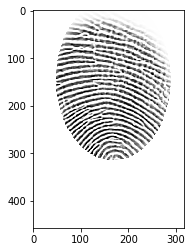

In [22]:
plt.imshow(crop_ellipse(crop_roi(image)), cmap = cm.Greys_r)

## Pad image to uniform size

In [25]:
def pad_image(image, size=(350, 250)):
    rows, cols = image.shape
    result = np.ones(size) * 255

    offset_x = (size[0] - rows) // 2
    offset_y = (size[1] - cols) // 2
    
    result[offset_x:(offset_x + rows), offset_y:(offset_y + cols)] = image
    
    return result

## Function to sample new croped image

In [32]:
crop_image = lambda image, tol=250: pad_image(crop_roi(crop_ellipse(crop_roi(image, tol)), tol))

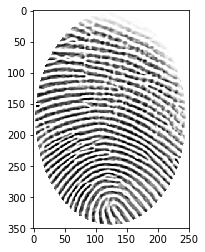

In [33]:
plt.imshow(crop_image(image), cmap = cm.Greys_r)

## Mirror image

In [34]:
mirror_image = lambda image: image[:, ::-1]

In [ ]:
mirror_2_image = lambda image: image[::-1, ::-1]

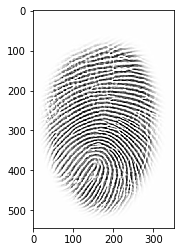

In [35]:
plt.imshow(mirror_image(image), cmap = cm.Greys_r)

## Re-scale images

In [37]:
scale_image = lambda image: image * (1. / 255) - 0.5

[[ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]
 [ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]
 [ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]
 ..., 
 [ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]
 [ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]
 [ 0.49607849  0.49607849  0.49607849 ...,  0.49607849  0.49607849
   0.49607849]]


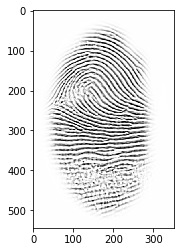

In [43]:
scaled_images = scale_image(images[:5])
print(scaled_images[1])
plt.imshow(scaled_images[4], cmap = cm.Greys_r)

# Write to TFRecords

In [44]:
# TFRecord helper functions
get_tfr_writer = lambda filename: tf.python_io.TFRecordWriter(filename)
_int64_feature = lambda value: tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
_bytes_feature = lambda value: tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [45]:
def write_tfrecords_to_file(writer, image, label):
    feature = {'label': _int64_feature(label),
               'image': _bytes_feature(tf.compat.as_bytes(image.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())

In [46]:
def augment_data(images, labels, n_crops=5, mirror=True):    
    # Create tfr writers
    splits = ['train', 'test', 'val']
    writers = {x: get_tfr_writer('nabard-augmented-{}.tfr'.format(x)) for x in splits}
    
    X, y = {}, {}
    
    # 15% test set     
    X['train'], X['test'], y['train'], y['test'] = train_test_split(images, labels, 
                                                                    test_size=0.15, random_state=1)
    # 12.75% validation set
    X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], 
                                                                  test_size=0.15, random_state=1)
    for split, writer in writers.items():
        for i in range(X[split].shape[0]):
            for _ in range(n_crops):
                # Transform image                 
                image = crop_image(X[split][i])
                image = scale_image(image)
                
                # Cast to the correct datatype                 
                image = image.astype(np.float32)
                label = y[split][i].astype(np.int64)
                
                write_tfrecords_to_file(writer, image, label)
                if mirror:
                    write_tfrecords_to_file(writer, mirror_image(image), label)
        writer.close()

In [47]:
# augment_data(images, labels)

# Load images from the TFRecords file

In [48]:
def decode(serialized_example):
    """Parses an image and label from the given `serialized_example`."""
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })

    # Convert from a scalar string tensor (whose single string has
    # length 350 * 250) to a float64 tensor with shape
    # [350 * 250].
    image = tf.decode_raw(features['image'], tf.float32)
    image.set_shape((350 * 250))
    image = tf.reshape(image, [350, 250])
    
    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int64)

    return image, label

In [49]:
def inputs(filename, batch_size, num_epochs):
    """Reads input data num_epochs times.
    Args:
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
       train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, 350, 250]
      in the range [-0.5, 0.5].
    * labels is an int64 tensor with shape [batch_size] with the true label.

    This function creates a one_shot_iterator, meaning that it will only iterate
    over the dataset once. On the other hand there is no special initialization
    required.
    """
    if not num_epochs:
        num_epochs = None
    
    filename = os.path.join("./", filename)

    with tf.name_scope('input'):
        # TFRecordDataset opens a binary file and reads one record at a time.
        # `filename` could also be a list of filenames, which will be read in order.
        dataset = tf.data.TFRecordDataset(filename)

        # The map transformation takes a function and applies it to every element
        # of the dataset.
        dataset = dataset.map(decode)

        # The shuffle transformation uses a finite-sized buffer to shuffle elements
        # in memory. The parameter is the number of elements in the buffer. For
        # completely uniform shuffling, set the parameter to be the same as the
        # number of elements in the dataset.
        dataset = dataset.shuffle(1000 + 3 * batch_size)

        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(batch_size)

        iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [52]:
def show_samples_from_tfr(filename):
    """Show sample images from a TFRecords file."""
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Input images and labels.
        image_batch, label_batch = inputs(
            filename=filename, batch_size=32, num_epochs=1)

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        
        # Create a session for running operations in the Graph.
        with tf.Session() as sess:
            # Initialize the variables (the trained variables and the
            # epoch counter).
            sess.run(init_op)
            image, label = sess.run([image_batch, label_batch])
            print(image[0])
            for j in range(6):
                plt.subplot(2, 3, j + 1)
                plt.imshow(image[j], cmap = cm.Greys_r)
                plt.title(label[j])
            plt.show()

[[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 ..., 
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]]


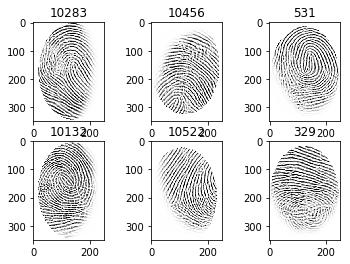

In [53]:
filename = 'nabard-augmented-test.tfr' 
show_samples_from_tfr(filename)